In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
email_df = pd.read_csv('email_table.csv')
opened_df = pd.read_csv('email_opened_table.csv')
clicked_df = pd.read_csv('link_clicked_table.csv')

In [ ]:
email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

In [ ]:
total_emails_sent = len(email_df)

# Number of emails opened
total_emails_opened = len(opened_df)

# Number of emails clicked
total_emails_clicked = len(clicked_df)

# Calculate percentages
open_rate = (total_emails_opened / total_emails_sent) * 100
click_rate = (total_emails_clicked / total_emails_sent) * 100

print(f"Email Open Rate: {open_rate:.2f}%")
print(f"Link Click Rate: {click_rate:.2f}%")

Email Open Rate: 10.35%
Link Click Rate: 2.12%


In [ ]:
def preprocess_data(df):
    # Convert categorical features
    df['email_text'] = df['email_text'].map({'long_text': 1, 'short_text': 0})
    df['email_version'] = df['email_version'].map({'personalized': 1, 'generic': 0})

    # Time-based features
    df['hour'] = df['hour'].astype(int)
    df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)
    df['is_morning'] = ((df['hour'] >= 6) & (df['hour'] <= 11)).astype(int)

    # Day of week features
    weekday_map = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
    df['weekday_num'] = df['weekday'].map(weekday_map)
    df['is_weekend'] = df['weekday'].isin(['Sat', 'Sun']).astype(int)

    df['new_user'] = (df['user_past_purchases'] == 0).astype(int)
    df['frequent_user'] = (df['user_past_purchases'] >= 3).astype(int)

    return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
processed_df = preprocess_data(email_df.copy())

In [ ]:
features = ['email_text', 'email_version', 'hour', 'is_business_hours', 'is_morning',
            'weekday_num', 'is_weekend', 'user_country', 'user_past_purchases',
            'new_user', 'frequent_user']

categorical_features = ['user_country']
numeric_features = [f for f in features if f not in categorical_features]

X = processed_df[features]
y = processed_df['clicked']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# %%
# Build the model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=42
    ))
])

In [ ]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['email_text',
                                                   'email_version', 'hour',
                                                   'is_business_hours',
                                                   'is_morning', 'weekday_num',
                                                   'is_weekend',
                                                   'user_past_purchases',
                                                   'new_user',
                                                   'frequent_user']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['user_country'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        min_samples_leaf=10,
                                        random_state=42))])

In [ ]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [ ]:
print("Model Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

Model Performance:
              precision    recall  f1-score   support

           0       0.99      0.62      0.76     19576
           1       0.04      0.72      0.07       424

    accuracy                           0.62     20000
   macro avg       0.51      0.67      0.42     20000
weighted avg       0.97      0.62      0.75     20000

ROC AUC: 0.7338


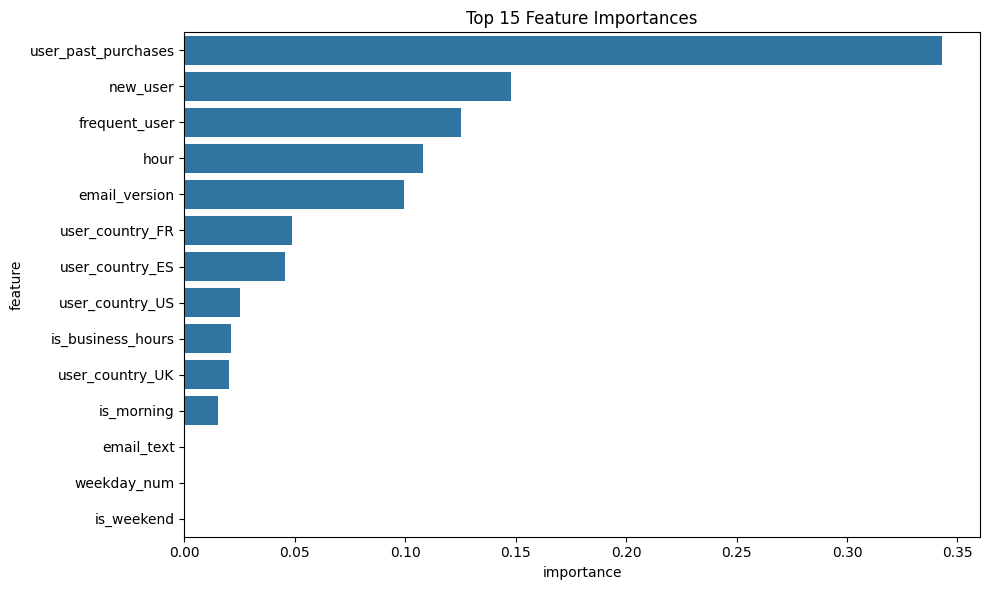

In [ ]:
feature_names = numeric_features + list(model.named_steps['preprocessor']
                                      .named_transformers_['cat']
                                      .get_feature_names_out(categorical_features))

importances = model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

In [ ]:
def simulate_campaign_improvement(model, X_test, y_test, percentiles):
    results = []
    y_prob = model.predict_proba(X_test)[:, 1]

    for p in percentiles:
        threshold = np.percentile(y_prob, 100 - p)
        mask = y_prob >= threshold
        ctr = y_test[mask].mean()
        results.append((p, threshold, ctr, mask.sum()))

    return pd.DataFrame(results, columns=['percentile', 'threshold', 'ctr', 'users_reached'])

In [ ]:
percentiles = np.arange(10, 110, 10)
sim_results = simulate_campaign_improvement(model, X_test, y_test, percentiles)

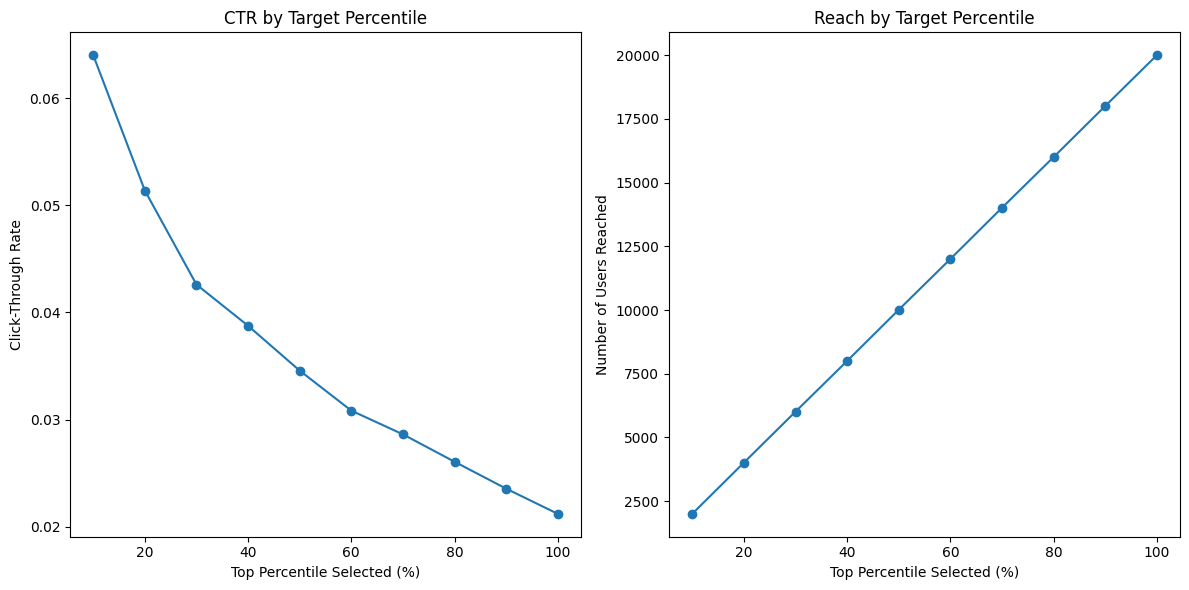

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(sim_results['percentile'], sim_results['ctr'], marker='o')
plt.xlabel('Top Percentile Selected (%)')
plt.ylabel('Click-Through Rate')
plt.title('CTR by Target Percentile')

plt.subplot(1, 2, 2)
plt.plot(sim_results['percentile'], sim_results['users_reached'], marker='o')
plt.xlabel('Top Percentile Selected (%)')
plt.ylabel('Number of Users Reached')
plt.title('Reach by Target Percentile')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate CTR for personalized vs generic emails
email_version_ctr = processed_df.groupby('email_version')['clicked'].mean()

print("Click-Through Rate by Email Version:")
print(email_version_ctr)

Click-Through Rate by Email Version:
email_version
0    0.015137
1    0.027294
Name: clicked, dtype: float64



CTR by Country:
user_country
UK    0.024675
US    0.024360
ES    0.008327
FR    0.008004
Name: clicked, dtype: float64


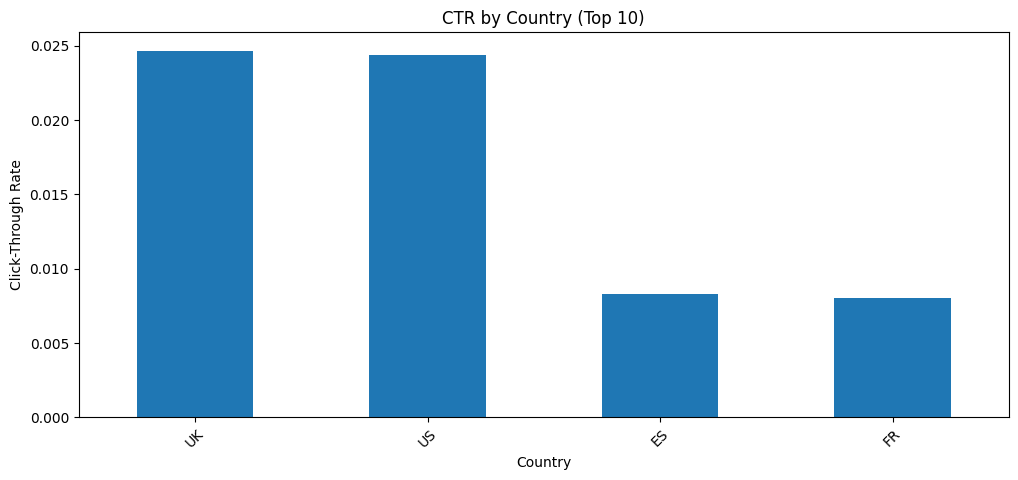

In [ ]:
# Calculate CTR by country
country_ctr = processed_df.groupby('user_country')['clicked'].mean().sort_values(ascending=False)

print("\nCTR by Country:")
print(country_ctr)

# Visualization - Top 10 countries
plt.figure(figsize=(12,5))
country_ctr.head(10).plot(kind='bar')
plt.title('CTR by Country (Top 10)')
plt.xlabel('Country')
plt.ylabel('Click-Through Rate')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Additional analysis functions for 15% and 10%
def analyze_top_percentile(model, X_test, y_test, percentile):
    y_prob = model.predict_proba(X_test)[:, 1]
    threshold = np.percentile(y_prob, 100 - percentile)
    mask = y_prob >= threshold

    return {
        'percentile': percentile,
        'threshold': threshold,
        'ctr': y_test[mask].mean(),
        'users_reached': mask.sum(),
        'total_clicks': y_test[mask].sum(),
        'baseline_expected_clicks': y_test.mean() * mask.sum()
    }

def compare_strategies(model, X_test, y_test, percentiles):
    results = []
    for p in percentiles:
        results.append(analyze_top_percentile(model, X_test, y_test, p))
    return pd.DataFrame(results)

In [ ]:
# Analyze multiple strategies
strategies = [1, 5, 10, 15, 20]
strategy_results = compare_strategies(model, X_test, y_test, strategies)

# Add baseline for comparison
baseline_ctr = y_test.mean()
strategy_results = pd.concat([
    pd.DataFrame([{
        'percentile': 100,
        'threshold': 0,
        'ctr': baseline_ctr,
        'users_reached': len(y_test),
        'total_clicks': y_test.sum(),
        'baseline_expected_clicks': y_test.sum()
    }]),
    strategy_results
])

print("Strategy Comparison:")
display(strategy_results[['percentile', 'users_reached', 'ctr', 'total_clicks']])

Strategy Comparison:


,percentile,users_reached,ctr,total_clicks
0,100,20000,0.021200,424
0,1,208,0.096154,20
1,5,1001,0.083916,84
2,10,2000,0.064000,128
3,15,3014,0.057731,174
4,20,4010,0.051372,206


In [ ]:
# Calculate improvements
for p in [1, 5, 10, 15, 20]:
    res = strategy_results[strategy_results['percentile'] == p].iloc[0]
    improvement = (res['ctr'] - baseline_ctr) / baseline_ctr * 100
    efficiency = res['total_clicks'] / res['users_reached']

    print(f"\nTop {p}% Strategy:")
    print(f"- CTR: {res['ctr']:.4f} ({improvement:.1f}% improvement)")
    print(f"- Users reached: {res['users_reached']} ({res['users_reached']/len(y_test):.1%} of total)")
    print(f"- Total clicks: {res['total_clicks']} (vs {res['baseline_expected_clicks']:.1f} expected from random)")
    print(f"- Efficiency: {efficiency:.2%} of reached users click")


Top 1% Strategy:
- CTR: 0.0962 (353.6% improvement)
- Users reached: 208.0 (1.0% of total)
- Total clicks: 20.0 (vs 4.4 expected from random)
- Efficiency: 9.62% of reached users click

Top 5% Strategy:
- CTR: 0.0839 (295.8% improvement)
- Users reached: 1001.0 (5.0% of total)
- Total clicks: 84.0 (vs 21.2 expected from random)
- Efficiency: 8.39% of reached users click

Top 10% Strategy:
- CTR: 0.0640 (201.9% improvement)
- Users reached: 2000.0 (10.0% of total)
- Total clicks: 128.0 (vs 42.4 expected from random)
- Efficiency: 6.40% of reached users click

Top 15% Strategy:
- CTR: 0.0577 (172.3% improvement)
- Users reached: 3014.0 (15.1% of total)
- Total clicks: 174.0 (vs 63.9 expected from random)
- Efficiency: 5.77% of reached users click

Top 20% Strategy:
- CTR: 0.0514 (142.3% improvement)
- Users reached: 4010.0 (20.1% of total)
- Total clicks: 206.0 (vs 85.0 expected from random)
- Efficiency: 5.14% of reached users click
